# Resnet 18 on faces 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import resnet
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import resnet


In [2]:
batchsize = 75
rate = 0.1
epochs = 200
lr_decay = 0.85
lr_stride = 5

In [3]:
class FaceDataset(torch.utils.data.Dataset):

    def __init__(self, transform, train=True):
        self.image_prefix = "face_renders/face"
        self.image_suffix = ".jpg"
        self.vertex_prefix = "processed_faces/face"
        self.vertex_suffix = ".txt"
        self.count = 5000
        self.trainn = 4500
        
        self.train = train
        self.transform = transform
        
        shape = np.loadtxt(self.vertex_prefix + str(1) + self.vertex_suffix).shape
        tmp = np.zeros((self.count, shape[0], shape[1]))
        for i in range(self.count):
            tmp[i] = np.loadtxt(self.vertex_prefix + str(i + 1) + self.vertex_suffix)
            
        self.mean = np.mean(tmp, axis=0)
        self.outputdim = shape[0] * shape[1]
        self.labels = [torch.from_numpy((lab - self.mean).reshape(self.outputdim)).float() for lab in tmp]
            
        # simple version for working with CWD
        

    def __len__(self):
        if self.train:
            return self.trainn
        else:
            return self.count - self.trainn

    def __getitem__(self, idx):
        if not train:
            idx += self.trainn
        y = self.labels[idx]
        x = plt.imread(self.image_prefix + str(idx + 1) + self.image_suffix)
        
        sample = (x,y)
        sample = (self.transform(sample[0]), sample[1])

        return sample

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = FaceDataset(transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = FaceDataset(transform, train=False)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("torch.cuda.is_available()   =", torch.cuda.is_available())
print("torch.cuda.device_count()   =", torch.cuda.device_count())
print("torch.cuda.device('cuda')   =", torch.cuda.device(0))
print("torch.cuda.current_device() =", torch.cuda.current_device())

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

torch.cuda.is_available()   = True
torch.cuda.device_count()   = 1
torch.cuda.device('cuda')   = <torch.cuda.device object at 0x00000272CB0349E8>
torch.cuda.current_device() = 0


In [6]:
model = resnet.resnet18(output_size=trainset.outputdim)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=rate)

criterion = nn.MSELoss()

def adjust_learning_rate(optimizer, epoch, decay, stride):
    lr = rate * (decay ** (epoch // stride))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [9]:
def train(model, optimizer, criterion, epochs, trainloader, testloader):
    model.train()
    samples = 1
    losses = []
    test_losses = []
    k = len(trainloader)// samples
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % k == k - 1:

                losses.append(running_loss / k)
                
                testloss = 0
                total = 0
                iterations = 0
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        outputs = model(images)
                        testloss += criterion(outputs, labels)
                        total += labels.size(0)
                        iterations += 1
                        if total > 200:
                            break
                test_losses.append(testloss / iterations)
                
                print('[%d, %5d] loss: %.3f test_loss: %.3f' %(epoch + 1, i + 1,losses[-1],test_losses[-1]))

                running_loss = 0.0
                
        adjust_learning_rate(optimizer, epoch+1, lr_decay, lr_stride)

    print('Finished Training')
    plt.plot(np.arange(0, len(losses)/samples, 1.0/samples), losses)
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
    plt.plot(np.arange(0, len(test_losses)/samples, 1.0/samples), test_losses)
    plt.title("test_loss")
    plt.xlabel("epoch")
    plt.ylabel("test_losses")
    plt.show()


[1,    90] loss: 7.498 test_loss: 7.152
[2,    90] loss: 6.272 test_loss: 5.867
[3,    90] loss: 5.566 test_loss: 5.639
[4,    90] loss: 5.390 test_loss: 5.425
[5,    90] loss: 5.160 test_loss: 5.088
[6,    90] loss: 4.810 test_loss: 4.738
[7,    90] loss: 4.547 test_loss: 4.489
[8,    90] loss: 4.346 test_loss: 4.347
[9,    90] loss: 4.209 test_loss: 4.223
[10,    90] loss: 4.093 test_loss: 4.085
[11,    90] loss: 3.953 test_loss: 3.975
[12,    90] loss: 3.836 test_loss: 3.839
[13,    90] loss: 3.725 test_loss: 3.688
[14,    90] loss: 3.628 test_loss: 3.537
[15,    90] loss: 3.503 test_loss: 3.403
[16,    90] loss: 3.373 test_loss: 3.336
[17,    90] loss: 3.276 test_loss: 3.236
[18,    90] loss: 3.206 test_loss: 3.141
[19,    90] loss: 3.156 test_loss: 3.091
[20,    90] loss: 3.088 test_loss: 3.042
[21,    90] loss: 3.011 test_loss: 2.966
[22,    90] loss: 2.949 test_loss: 2.929
[23,    90] loss: 2.904 test_loss: 2.877
[24,    90] loss: 2.868 test_loss: 2.837
[25,    90] loss: 2.843 t

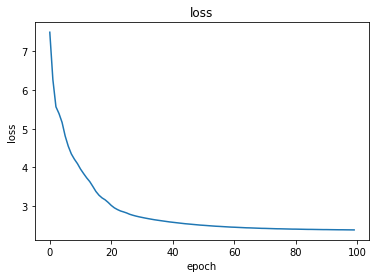

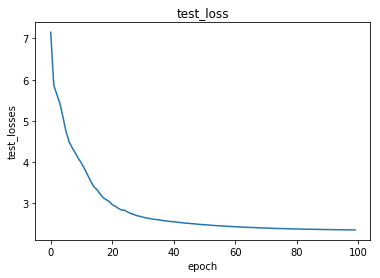

In [10]:
train(model, optimizer, criterion, epochs, trainloader, testloader)

In [11]:
torch.save(model.state_dict(), "res18b" + str(batchsize) + "r" + str(rate) + "e" + str(epochs) + ".statedict")

In [ ]:
with torch.no_grad():
    d = next(testloader.__iter__())
    images, labels = d
    outputs = model(images)
    
    print(trainset.mean)
    print(outputs[0])
    print(labels[0])
    print(np.linalg.norm((labels[0] - outputs[0]).to('cpu').numpy()))
    